# Here is the Step5 about SHD Dataset

控制实验1：随机删除 spike（固定神经元 + 固定总 spike 数）
实验目的：
探索：spike 总数对模型性能的影响，以及是否只是“信息量”而非“时序结构”影响性能。

操作方式：
- 使用与你在 f=0（即没有扰动）时相同的神经元集合；
- 保持这些神经元的 spike 总数不变；
- 从整个序列中随机地删除一些 spike，而不是扰动它们的时间或顺序。

背后逻辑：
- 你之前是通过 f 扰动 spike 的时间，破坏了 spike 的时间结构；
- 现在我们构造一个对照组，它不改变时间结构，只减少 spike 总量；
- 这能让你区分模型性能下降是因为 “结构信息丢失” 还是单纯因为 “信息量减少”。

预期现象：
- 如果模型性能保持不变 → spike 总数不关键，时间结构才是信息的核心；
- 如果性能显著下降 → spike 数量本身也承担了信息传递作用。

In [1]:
import pickle
import random
import numpy as np
from scipy import io
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as tnnf
from tqdm.notebook import tqdm
from utils import get_shd_dataset

ms = 1e-3 # use this constant so you can write e.g. 1*ms for a time

## Begin Here to Train

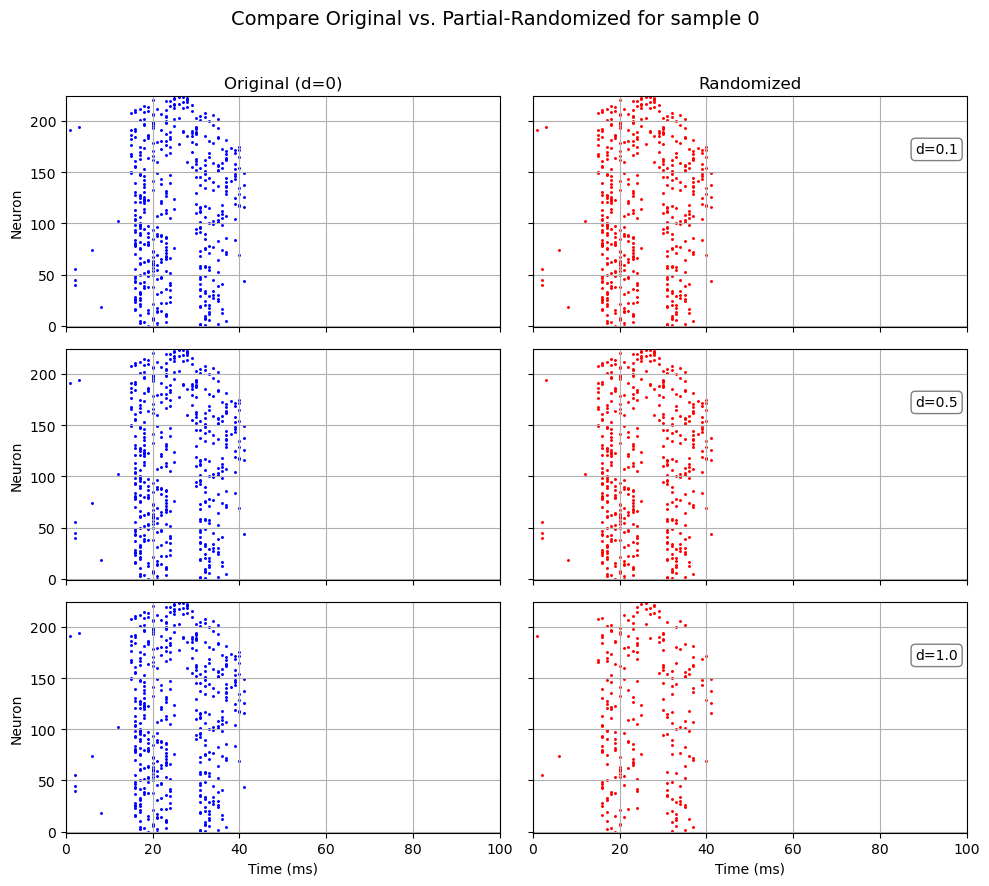

Using data index range = [0, 3276), total 3276 samples
batch_size=2
num_time_points=100
num_batches=1638
RAM usage per batch ~ 0.0003 GB
Got a batch: x_batch.shape=(2, 224, 100), y_batch=[ 6 12]


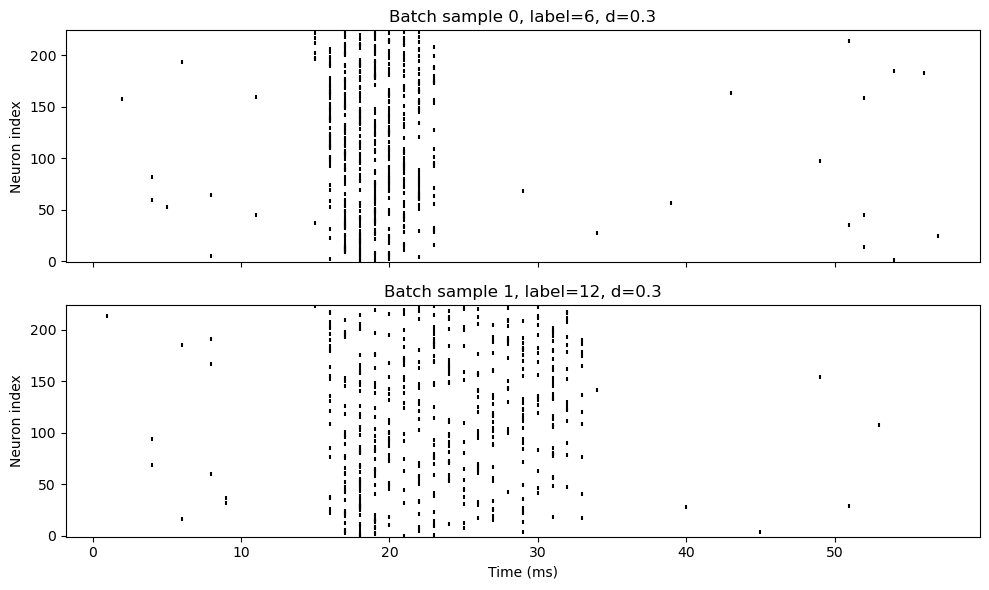

In [5]:
import numpy as np
import matplotlib.pyplot as plt

def partial_delete_spike_train(spike_train, d=0.5):
    """
    删除 spike：每个神经元保留 (1 - 0.5*d) 的脉冲。
    当 d=1 时，删除 50% spike。
    """
    if d <= 0:
        return spike_train

    num_neurons, T = spike_train.shape
    new_train = np.copy(spike_train)
    keep_ratio = 1.0 - 0.5 * d

    for neuron_idx in range(num_neurons):
        spike_times = np.where(spike_train[neuron_idx] == 1)[0]
        n_total = len(spike_times)
        n_keep = int(round(n_total * keep_ratio))

        if n_keep < n_total:
            keep_indices = np.random.choice(spike_times, n_keep, replace=False)
            new_train[neuron_idx] = 0
            new_train[neuron_idx, keep_indices] = 1

    return new_train

    
def num_batches_if(time_fractions, batch_size=32, max_num_batches=None):
    """
    return how many batches can be generated in the given time_fractions
    """
    f_start, f_end = time_fractions
    N = X.shape[0]
    start_idx = int(round(N * f_start))
    end_idx   = int(round(N * f_end))
    sub_len = end_idx - start_idx
    n_batches = sub_len // batch_size
    if max_num_batches is not None:
        n_batches = min(n_batches, max_num_batches)
    return n_batches

def batched_data(time_fractions, X, Y, batch_size=4, d=0.5,
                 verbose=False, shuffle=True, max_num_batches=None,
                 max_attempts=50):
    """
    for (x_batch, y_batch) in batched_data(...):
        # x_batch.shape = (batch_size, n_neurons, T)
        # y_batch.shape = (batch_size,)
    """
    N = len(Y)
    f_start, f_end = time_fractions
    start_idx = int(round(N * f_start))
    end_idx   = int(round(N * f_end))
    subX = X[start_idx:end_idx]  # [sub_len, n_neurons, T]
    subY = Y[start_idx:end_idx]  # [sub_len]
    sub_len = len(subY)

    indices = np.arange(sub_len)
    if shuffle:
        np.random.shuffle(indices)

    num_batches = sub_len // batch_size
    if max_num_batches is not None:
        num_batches = min(num_batches, max_num_batches)

    num_neurons = X.shape[1]
    num_time_points = X.shape[2]

    if verbose:
        print(f"Using data index range = [{start_idx}, {end_idx}), total {sub_len} samples")
        print(f"{batch_size=}")
        print(f"{num_time_points=}")
        print(f"{num_batches=}")
        print(f"RAM usage per batch ~ {batch_size * num_time_points * num_neurons * 8 / (1024)**3:.4f} GB")

    for b in range(num_batches):
        batch_idx = indices[b*batch_size : (b+1)*batch_size]
        x_batch = np.zeros((batch_size, subX.shape[1], subX.shape[2]), dtype=np.uint8)
        y_batch = np.zeros((batch_size,), dtype=np.int32)
        for i, sidx in enumerate(batch_idx):
            x_random = partial_delete_spike_train(subX[sidx], d=d)
            x_batch[i] = x_random
            y_batch[i] = subY[sidx]
        yield x_batch, y_batch

# Load SHD Dataset
from scipy.io import loadmat
data = loadmat("spikedata4_3.mat")
X = data["X"]
Y = data["Y"].ravel()
num_neurons = X.shape[1]
total_samples = X.shape[0]        

training_range   = (0, 0.6)   
validation_range = (0.6, 0.75)
testing_range    = (0.75, 0.9)

def show_single_sample_different_f(X, Y, sample_idx=0, d_values=[0.0, 0.3, 0.9]):
    """
    Do partial randomization for the same sample with different d values.
    """
    original_st = X[sample_idx]  # shape = (n_neurons, T)
    fig, axes = plt.subplots(len(d_values), 2, figsize=(10, 3 * len(d_values)), sharex=True, sharey=True)
    fig.suptitle(f"Compare Original vs. Partial-Randomized for sample {sample_idx}", fontsize=14)

    for row_i, d_ in enumerate(d_values):
        # Left: Original
        ax_left = axes[row_i, 0]
        for neuron_idx in range(original_st.shape[0]):
            spike_times = np.where(original_st[neuron_idx] == 1)[0]
            ax_left.scatter(spike_times, np.ones_like(spike_times)*neuron_idx,
                            s=5, color='b', marker='.')
        if row_i == 0:
            ax_left.set_title("Original (d=0)")
        ax_left.set_ylabel('Neuron')
        ax_left.grid(True)

        # Right: Partial Randomized
        x_rand = partial_delete_spike_train(original_st, d=d_)
        ax_right = axes[row_i, 1]
        for neuron_idx in range(x_rand.shape[0]):
            spike_times = np.where(x_rand[neuron_idx] == 1)[0]
            ax_right.scatter(spike_times, np.ones_like(spike_times)*neuron_idx,
                             s=5, color='r', marker='.')
        if row_i == 0:
            ax_right.set_title("Randomized")
        ax_right.text(0.98, 0.8, f"d={d_:.1f}", transform=ax_right.transAxes,
                      ha='right', va='top', fontsize=10,
                      bbox=dict(boxstyle="round", fc="white", ec="gray"))
        ax_right.grid(True)

        for ax in (ax_left, ax_right):
            ax.set_ylim([-1, original_st.shape[0]])
            ax.set_xlim([0, original_st.shape[1]])

    axes[-1, 0].set_xlabel('Time (ms)')
    axes[-1, 1].set_xlabel('Time (ms)')
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

def demo_batch_visualization(X, Y, time_fractions=(0, 0.2), batch_size=2, d=0.5):
    """
    Use batched_data() to get one batch and do visualization.
    """
    gen = batched_data(time_fractions, X, Y, batch_size=batch_size, d=d, shuffle=True, verbose=True)
    x_batch, y_batch = next(gen)
    print(f"Got a batch: x_batch.shape={x_batch.shape}, y_batch={y_batch}")

    fig, axes = plt.subplots(batch_size, 1, figsize=(10, 3*batch_size), sharex=True, sharey=True)
    if batch_size == 1:
        axes = [axes]

    for i in range(batch_size):
        ax = axes[i]
        spike_mat = x_batch[i]  # shape=(n_neurons, T)
        for neuron_idx in range(spike_mat.shape[0]):
            spike_times = np.where(spike_mat[neuron_idx] == 1)[0]
            ax.scatter(spike_times, np.ones_like(spike_times)*neuron_idx,
                       s=5, marker='|', color='black')
        ax.set_title(f"Batch sample {i}, label={y_batch[i]}, d={d}")
        ax.set_ylabel("Neuron index")
        ax.set_ylim([-1, spike_mat.shape[0]])
    axes[-1].set_xlabel("Time (ms)")
    plt.tight_layout()
    plt.show()


show_single_sample_different_f(X, Y, sample_idx=0, d_values=[0.1,0.5,1.0])
demo_batch_visualization(X, Y, time_fractions=training_range, batch_size=2, d=0.3)

## Build the Spiking Neural Network Model (SNN)

In [6]:
import torch
import torch.nn as nn
import numpy as np


class SurrGradSpike(torch.autograd.Function):
    scale = 100.0 

    @staticmethod
    def forward(ctx, input):
        """
        在 forward 中做 Heaviside(step) 函数
        """
        ctx.save_for_backward(input)
        out = torch.zeros_like(input)
        out[input > 0] = 1.0
        return out

    @staticmethod
    def backward(ctx, grad_output):
        """
        surrogate gradient: d/dx of H(x) ≈ 1/(scale*|x|+1)^2
        """
        (inp,) = ctx.saved_tensors
        grad_input = grad_output.clone()
        grad = grad_input / (SurrGradSpike.scale*torch.abs(inp) + 1.0)**2
        return grad

spike_fn = SurrGradSpike.apply

# 1) hidden Layer w1 & v1 + (syn, mem) Update
# 2) readout Layer w2 + flt, out Update
# 3) Finally return out_rec, [mem_rec, spk_rec]
class TutorialSNN(nn.Module):
    def __init__(self,nb_inputs=224,nb_hidden=200,nb_outputs=20,time_step=1e-3,
                 tau_mem=10e-3,tau_syn=5e-3,weight_scale=0.2,device='cpu'):
        """
        w1, w2, v1 都用 normal_(..., std=weight_scale/sqrt(...))
        alpha, beta = exp(-dt/tau_syn), exp(-dt/tau_mem)
        """
        super().__init__()

        self.nb_inputs  = nb_inputs
        self.nb_hidden  = nb_hidden
        self.nb_outputs = nb_outputs
        self.time_step  = time_step
        self.tau_mem    = tau_mem
        self.tau_syn    = tau_syn
        self.device_str = device

        # w1 => (n_in, n_hidden)
        self.w1 = nn.Parameter(torch.empty((nb_inputs, nb_hidden), dtype=torch.float))
        # v1 => (n_hidden, n_hidden)
        self.v1 = nn.Parameter(torch.empty((nb_hidden, nb_hidden), dtype=torch.float))
        # w2 => (n_hidden, n_outputs)
        self.w2 = nn.Parameter(torch.empty((nb_hidden, nb_outputs), dtype=torch.float))

        # init
        torch.nn.init.normal_(self.w1, mean=0.0, std=weight_scale/np.sqrt(nb_inputs))
        torch.nn.init.normal_(self.w2, mean=0.0, std=weight_scale/np.sqrt(nb_hidden))
        torch.nn.init.normal_(self.v1, mean=0.0, std=weight_scale/np.sqrt(nb_hidden))

        # alpha, beta
        self.alpha = float(np.exp(-time_step / tau_syn))
        self.beta  = float(np.exp(-time_step / tau_mem))

    def forward(self, inputs, dtype=torch.float32):
        """
        inputs shape = (batch_size, nb_steps, nb_inputs)
        h1_from_input = einsum('abc,cd->abd',(inputs, w1))
        Finally return out_rec, [mem_rec, spk_rec]
        """
        if inputs.dim() == 3:
            inputs = inputs.permute(0, 2, 1)  # (B, T, input_size)

        device = torch.device(self.device_str if torch.cuda.is_available() else 'cpu')
        inputs = inputs.to(device=device, dtype=dtype)
        batch_size, nb_steps, _ = inputs.shape 

        # hidden states
        syn = torch.zeros((batch_size, self.nb_hidden), device=device, dtype=dtype)
        mem = torch.zeros((batch_size, self.nb_hidden), device=device, dtype=dtype)
        out = torch.zeros((batch_size, self.nb_hidden), device=device, dtype=dtype)

        mem_rec = []
        spk_rec = []

        # 1) Calculate input->hidden
        # inputs shape => (B,T,n_in) w1 => (n_in,n_hidden) => result => (B,T,n_hidden)
        h1_from_input = torch.einsum("abc,cd->abd", (inputs, self.w1.to(inputs.device)))

        # 2) nb_steps
        for t in range(nb_steps):
            # recurrent: out =>(B,n_hidden), v1=>(n_hidden,n_hidden) => shape(B,n_hidden)
            rec_input = torch.einsum("ab,bc->ac", (out, self.v1.to(inputs.device)))
            h1 = h1_from_input[:, t, :] + rec_input

            # mem-1 => spike
            mthr = mem - 1.0
            out_new = spike_fn(mthr)
            rst = out_new.detach()  # not backprop

            # new_syn= alpha*syn + h1
            # new_mem= (beta*mem + syn)*(1.0 - rst)
            new_syn = self.alpha*syn + h1
            new_mem = (self.beta*mem + syn)*(1.0 - rst)
            mem_rec.append(mem)
            spk_rec.append(out_new)
            mem = new_mem
            syn = new_syn
            out = out_new

        mem_rec = torch.stack(mem_rec, dim=1)
        spk_rec = torch.stack(spk_rec, dim=1)

        # 3) readout layer
        #  spk_rec => shape(B, nb_steps, n_hidden)
        h2 = torch.einsum("abc,cd->abd", (spk_rec, self.w2.to(inputs.device)))

        # flt, out =>(B, nb_outputs)
        flt = torch.zeros((batch_size, self.nb_outputs), device=device, dtype=dtype)
        out_read = torch.zeros((batch_size, self.nb_outputs), device=device, dtype=dtype)
        out_rec = [out_read]

        for t in range(nb_steps):
            new_flt = self.alpha*flt + h2[:, t, :]
            new_out = self.beta*out_read + flt
            flt = new_flt
            out_read = new_out
            out_rec.append(out_read)

        # =>(nb_steps+1, B, nb_outputs)->(B, nb_steps+1, nb_outputs)
        out_rec = torch.stack(out_rec, dim=1)
        other_recs = [mem_rec, spk_rec]
        return out_rec, other_recs


In [11]:
import torch
import torch.nn.functional as F
import numpy as np

num_classes = 20

def evaluate_network(net, time_fractions, batch_size=64, d=0.0, device='cpu'):
    """
    Evaluate: max-over-time + NLL loss + null baseline
    """
    net.eval()
    losses = []
    null_losses = []
    log_softmax_fn = torch.nn.LogSoftmax(dim=1)
    loss_fn = torch.nn.NLLLoss()

    with torch.no_grad():
        gen = batched_data(time_fractions, X, Y,batch_size=batch_size,d=d, shuffle=False,max_num_batches=2)
        for x_np, y_np in gen:
            x_t = torch.tensor(x_np, dtype=torch.float32, device=device)
            y_t = torch.tensor(y_np, dtype=torch.long, device=device)

            out_rec, other_recs = net(x_t)
            m, _ = torch.max(out_rec, dim=1)  # => (B, nb_outputs)
            log_probs = log_softmax_fn(m)

            y_t = y_t.to(log_probs.device)
            loss_val = loss_fn(log_probs, y_t)
            losses.append(loss_val.item())

            # null_loss: log_softmax(zeros)
            zero_logits = torch.zeros_like(m)
            null_lp = log_softmax_fn(zero_logits)
            null_val = loss_fn(null_lp, y_t)
            null_losses.append(null_val.item())

    avg_loss = np.mean(losses) if len(losses) else 0.
    avg_null = np.mean(null_losses) if len(null_losses) else 0.
    return avg_loss, avg_null

## 对每个 batch -> run_snn-> out_rec + spk_rec 计算 cross_entropy + spike regularizer 优化器用 Adamax
def train_model(d=0.0, num_epochs=100, batch_size=64, max_num_batches=40,
                lr=2e-4, hidden_units=200, device='cuda', seed=42):
    print(f"\n=== Training model with d={d}, num_epochs={num_epochs}, seed={seed} ===")

    torch.manual_seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

    dev = torch.device(device if torch.cuda.is_available() else "cpu")
    print(f"Using device: {dev}")

    net = TutorialSNN(num_neurons, hidden_units, num_classes).to(dev)

    optimizer = torch.optim.Adamax(net.parameters(), lr=lr, betas=(0.9, 0.999))

    log_softmax_fn = torch.nn.LogSoftmax(dim=1)
    loss_fn = torch.nn.NLLLoss()

    loss_hist, val_loss_hist = [], []
    best_val_loss = float('inf')
    best_model_state = None

    train_batches = num_batches_if(training_range,batch_size=batch_size,max_num_batches=max_num_batches)
    total_batches = num_epochs * train_batches

    from tqdm import tqdm
    with tqdm(total=total_batches) as pbar:
        for epoch in range(num_epochs):
            net.train()
            local_losses = []

            train_gen = batched_data(training_range, X, Y, batch_size=batch_size, d=d,
                                     shuffle=True, verbose=(epoch==0), max_num_batches=max_num_batches)

            for x_np, y_np in train_gen:
                x_t = torch.tensor(x_np, dtype=torch.float32, device=dev)
                y_t = torch.tensor(y_np, dtype=torch.long, device=dev)

                out_rec, other_recs = net(x_t)
                spk_rec = other_recs[1]

                m, _ = torch.max(out_rec, dim=1)
                log_probs = log_softmax_fn(m)

                l1_loss = 2e-6 * torch.sum(spk_rec)
                sum_per_neuron = torch.sum(spk_rec, dim=[0,1])  # (hidden,)
                l2_loss = 2e-6 * torch.mean(sum_per_neuron**2)

                reg_loss = l1_loss + l2_loss

                y_t = y_t.to(log_probs.device)
                loss_val = loss_fn(log_probs, y_t) + reg_loss
                local_losses.append(loss_val.item())

                optimizer.zero_grad()
                loss_val.backward()
                optimizer.step()

                pbar.update(1)

            last_epoch_loss = np.mean(local_losses) if local_losses else 0.
            val_loss, null_val_loss = evaluate_network(net,validation_range,batch_size=64,d=d,device=dev)

            val_loss_hist.append(val_loss)
            loss_hist.append(last_epoch_loss)

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model_state = net.state_dict()

            pbar.set_postfix(epoch=epoch,train_loss=last_epoch_loss,val_loss=val_loss,null_val=null_val_loss)

    import matplotlib.pyplot as plt
    plt.figure()
    plt.semilogy(loss_hist, label='Train loss')
    plt.semilogy(val_loss_hist, label='Val loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()

    if best_model_state is not None:
        net.load_state_dict(best_model_state)
        print(f"Loaded best model with val_loss={best_val_loss:.4f}")

    test_loss, null_test_loss = evaluate_network(net,testing_range,batch_size=64,d=d,device=dev)
    print(f"Final Test: test_loss={test_loss:.4f}, null_test_loss={null_test_loss:.4f}")

    return net, best_val_loss

def test_accuracy(net, time_fractions=testing_range, batch_size=64, d=0, device='cpu'):
    net.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        gen = batched_data(time_fractions, X, Y,batch_size=batch_size,d=d,shuffle=False,max_num_batches=40)
        for x_np, y_np in gen:
            x_t = torch.tensor(x_np, dtype=torch.float32, device=device)
            y_t = torch.tensor(y_np, dtype=torch.long, device=device)

            out_rec, _ = net(x_t, dtype=x_t.dtype)

            # max over time => (B,O)
            m, _ = torch.max(out_rec, dim=1)
            preds = torch.argmax(m, dim=1)  # shape=(B,)

            y_t = y_t.to(preds.device)
            correct += (preds == y_t).sum().item()
            total   += y_t.shape[0]

    acc = correct/total if total>0 else 0.
    return acc



### Training model for d = 0.0 ###

=== Training model with d=0.0, num_epochs=150, seed=42 ===
Using device: cuda


  0%|          | 0/6000 [00:00<?, ?it/s]

Using data index range = [0, 3276), total 3276 samples
batch_size=64
num_time_points=100
num_batches=40
RAM usage per batch ~ 0.0107 GB


100%|██████████| 6000/6000 [28:43<00:00,  3.48it/s, epoch=149, null_val=3, train_loss=0.597, val_loss=2.01]


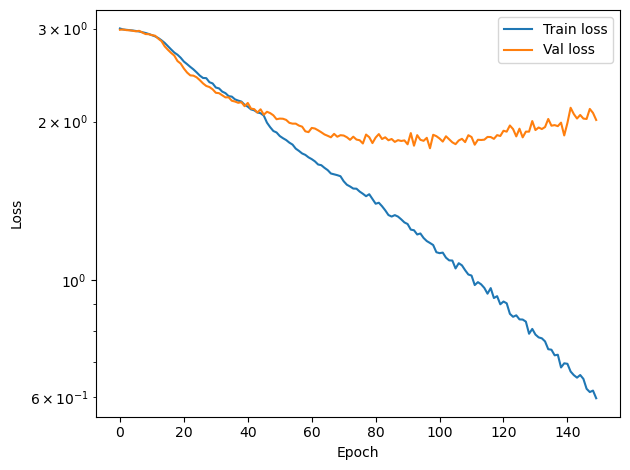

Loaded best model with val_loss=1.7795
Final Test: test_loss=2.0331, null_test_loss=2.9957
Saved model: s5_f00.pt
d=0.0, Test Accuracy: 36.33%

### Training model for d = 0.2 ###

=== Training model with d=0.2, num_epochs=150, seed=42 ===
Using device: cuda


  0%|          | 0/6000 [00:00<?, ?it/s]

Using data index range = [0, 3276), total 3276 samples
batch_size=64
num_time_points=100
num_batches=40
RAM usage per batch ~ 0.0107 GB


  1%|          | 50/6000 [00:14<29:37,  3.35it/s, epoch=0, null_val=3, train_loss=3, val_loss=2.99]


KeyboardInterrupt: 

In [ ]:
d_values = [0.0]

for d in d_values:
    print(f"\n### Training model for d = {d} ###")

    var_name = f"net_{int(d * 10):02d}" 
    net, val_loss = train_model(d=d, num_epochs=150)
    globals()[var_name] = net
    model_path = f"s5_d{int(d * 10):02d}.pt"
    torch.save(net.state_dict(), model_path)
    print(f"Saved model: {model_path}")
    acc = test_accuracy(net, testing_range, batch_size=128, d=d, device='cuda')
    print(f"d={d:.1f}, Test Accuracy: {acc:.2%}")

## Evaluation

Using device: cuda

=== Loading model s4_3_f00.pt and testing ===
f=0.0, Test Accuracy: 36.33%

=== Loading model s4_3_f01.pt and testing ===
f=0.1, Test Accuracy: 37.24%

=== Loading model s4_3_f02.pt and testing ===
f=0.2, Test Accuracy: 38.41%

=== Loading model s4_3_f03.pt and testing ===
f=0.3, Test Accuracy: 36.07%

=== Loading model s4_3_f04.pt and testing ===
f=0.4, Test Accuracy: 31.51%

=== Loading model s4_3_f05.pt and testing ===
f=0.5, Test Accuracy: 25.13%

=== Loading model s4_3_f06.pt and testing ===
f=0.6, Test Accuracy: 20.96%

=== Loading model s4_3_f07.pt and testing ===
f=0.7, Test Accuracy: 13.41%

=== Loading model s4_3_f08.pt and testing ===
f=0.8, Test Accuracy: 4.82%

=== Loading model s4_3_f09.pt and testing ===
f=0.9, Test Accuracy: 6.12%

=== Loading model s4_3_f10.pt and testing ===
f=1.0, Test Accuracy: 6.25%


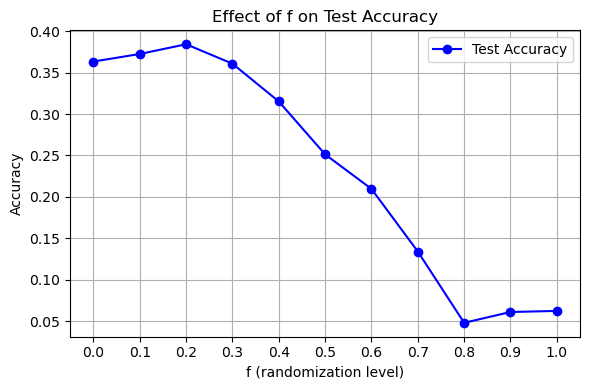

In [ ]:
import torch
import matplotlib.pyplot as plt
from scipy import io

data = io.loadmat('spikedata4_3.mat')
X = data['X']  # (N, num_neurons, T)
Y = data['Y'].ravel()

d_values = [0.0,0.2,0.4,0.6,0.8,1.0]
accuracies = []

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

for f in f_values:
    model_path = f"s5_d{int(f*10):02d}.pt"
    print(f"\n=== Loading model {model_path} and testing ===")

    net = TutorialSNN(num_neurons, 200, num_classes)
    net.load_state_dict(torch.load(model_path, map_location=device))
    net.to(device)

    acc = test_accuracy(net, time_fractions=testing_range, batch_size=256, d=d, device=device)
    accuracies.append(acc)
    print(f"d={d:.1f}, Test Accuracy: {acc:.2%}")

plt.figure(figsize=(6, 4))
plt.plot(f_values, accuracies, marker='o', linestyle='-', color='b', label="Test Accuracy")
plt.xlabel("d (delete level)")
plt.ylabel("Accuracy")
plt.title("Effect of f on Test Accuracy")
plt.xticks(f_values)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



=== Loading model s4_3_f00.pt and testing (f=0.0) ===
f=0.0, Mean Acc=36.33%, Std=0.00% (over 5 runs)

=== Loading model s4_3_f01.pt and testing (f=0.1) ===
f=0.1, Mean Acc=38.52%, Std=1.09% (over 5 runs)

=== Loading model s4_3_f02.pt and testing (f=0.2) ===
f=0.2, Mean Acc=37.97%, Std=0.64% (over 5 runs)

=== Loading model s4_3_f03.pt and testing (f=0.3) ===
f=0.3, Mean Acc=36.12%, Std=0.73% (over 5 runs)

=== Loading model s4_3_f04.pt and testing (f=0.4) ===
f=0.4, Mean Acc=31.93%, Std=0.44% (over 5 runs)

=== Loading model s4_3_f05.pt and testing (f=0.5) ===
f=0.5, Mean Acc=26.04%, Std=0.98% (over 5 runs)

=== Loading model s4_3_f06.pt and testing (f=0.6) ===
f=0.6, Mean Acc=21.33%, Std=1.23% (over 5 runs)

=== Loading model s4_3_f07.pt and testing (f=0.7) ===
f=0.7, Mean Acc=14.09%, Std=0.66% (over 5 runs)

=== Loading model s4_3_f08.pt and testing (f=0.8) ===
f=0.8, Mean Acc=4.64%, Std=0.24% (over 5 runs)

=== Loading model s4_3_f09.pt and testing (f=0.9) ===
f=0.9, Mean Acc=5.8

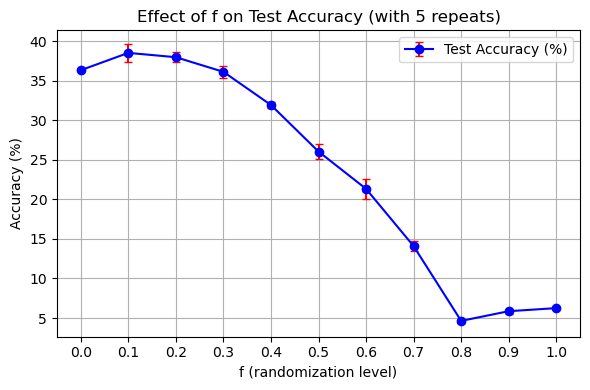

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy import io

def test_accuracy_repeats(net, repeats=5, f=0.0):
    """
    在相同 f 值下, 测试 repeats 次 (若 test_accuracy 有随机因素, 重复测可产生波动)
    返回 长度为 repeats 的准确率列表
    """
    acc_list = []
    for r in range(repeats):
        # 如果测试过程有 seed 之类的, 可以在这里设定 torch.manual_seed(...) 
        # or np.random.seed(...) 以便每次略有不同

        acc = test_accuracy(net,
                            time_fractions=testing_range,
                            batch_size=256,
                            d=d,
                            device=device)
        acc_list.append(acc)
    return acc_list

all_means = []
all_stds = []

repeats = 5  # 例如跑5次

for f in f_values:
    model_path = f"s4_3_f{int(f*10):02d}.pt"
    print(f"\n=== Loading model {model_path} and testing (f={f}) ===")

    net = TutorialSNN(num_neurons, 200, num_classes)
    net.load_state_dict(torch.load(model_path, map_location=device))
    net.to(device)
    net.eval()

    # 多次测
    acc_list = test_accuracy_repeats(net, repeats=repeats, d=d)
    mean_acc = np.mean(acc_list)
    std_acc  = np.std(acc_list)

    all_means.append(mean_acc)
    all_stds.append(std_acc)

    print(f"f={f:.1f}, Mean Acc={mean_acc:.2%}, Std={std_acc:.2%} (over {repeats} runs)")


# -------------------
# 4) 绘制带误差棒的曲线
# -------------------
plt.figure(figsize=(6, 4))

# 将准确率转换成百分比或保持原小数也可以
means_pct = [m * 100 for m in all_means]
stds_pct  = [s * 100 for s in all_stds]

# 使用 errorbar 传入 yerr
plt.errorbar(f_values, means_pct, yerr=stds_pct,
             fmt='-o', color='b', ecolor='r', capsize=3,
             label='Test Accuracy (%)')

plt.xlabel("f (randomization level)")
plt.ylabel("Accuracy (%)")
plt.title(f"Effect of f on Test Accuracy (with {repeats} repeats)")
plt.xticks(f_values)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()